In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import texttable as tt
from sklearn import preprocessing
from sklearn import model_selection 
from sklearn import linear_model 
from sklearn import svm
from sklearn import neural_network

# Loading the data

In [2]:
data = pd.read_csv('data/train.csv', index_col='PassengerId')
del data.index.name # lets also remove this row with just the name on it to make things easier later
data_test = pd.read_csv('data/test.csv', index_col='PassengerId')
del data_test.index.name # lets also remove this row with just the name on it to make things easier later

In [3]:
data[0:3]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


So, what is the data we have to work with:

Survivied is our target variable we wish to predict, a value of 1 means survival, a value of 0 means death.

Pclass is a proxy for socio-economic status the values are as so:
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

SibSp quantifies how many siblings/spouses were aboard with the passenger.

Parch quantifies how many parents/children were aboard with the passenger.

Embarked codifies the port at which the passenger embarked as so:
- C = Cherbourg
- Q = Queenstown
- S = Southampton





# Feature Engineering / data Pre-processing

In order to use many machine learning algorithms we first have to do some preprocessing to get it into an appropriate format. We'll go through the features one at a time.

### Feature 1: Pclass

First lets check for missing data entries

In [4]:
print('Num of missing entries in training data = {}'.format(sum(np.isnan(data.Pclass))))
print('Num of missing entries in test data = {}'.format(sum(np.isnan(data_test.Pclass))))

Num of missing entries in training data = 0
Num of missing entries in test data = 0


There are no missing entries here so we move on.

Pclass is a categorical variable, these need to be encoded into binary variables. This is nessesary because of the way the algorithm interprets numbers. If we have a categorical feature that takes values 0, 1, 2, 3, 4 it assumes the higher numbers are 'better' (e.g. 4>3) even though they are arbitrary encodings, because ultimately it is calculating values/weights/parameters to be multiplied by these feature variables to give a term which enters into the linear regression. One common way to deal with this is one-hot-encoding, where a feature N takes values 0, 1, 2 for example we would generate 3 features which takes binary values 0 or 1. An example is shown below

We have the original feature data:

| Entry        | N          |
| ------------ |:----------:|
| 0            | 1          | 
| 1            | 2          |
| 2            | 0          |
| 3            | 1          |
| 4            | 2          |
| 5            | 0          |

Which when encoded becomes:

| Entry        | N==0       | N==1       | N==2       |
| ------------ |:----------:|:----------:|:----------:|
| 0            | 0          | 1          | 0          | 
| 1            | 0          | 0          | 1          | 
| 2            | 1          | 0          | 0          | 
| 3            | 0          | 1          | 0          | 
| 4            | 0          | 0          | 1          | 
| 5            | 1          | 0          | 0          | 

In [5]:
# on training data

Pclass_lb = preprocessing.LabelBinarizer()
Pclass_one_hot_encoded = Pclass_lb.fit(data['Pclass']) # one-hot encoding
Pclass_one_hot_encoded = Pclass_lb.transform(data['Pclass']) # one-hot encoding

dfOneHot_Encoded = pd.DataFrame(
    Pclass_one_hot_encoded, 
    columns = ["Pclass_"+str(int(i+1)) for i in range(Pclass_one_hot_encoded.shape[1])],
    index=data.index
    ) # we now construct a dataframe out of this one-hot-encoded data

# we now add our one-hot-encoded Embarked features
data = pd.concat([data, dfOneHot_Encoded], axis=1)
del(data['Pclass']) # and delete the original feature

# on testing data

Pclass_one_hot_encoded = Pclass_lb.transform(data_test['Pclass']) # one-hot encoding
dfOneHot_Encoded = pd.DataFrame(
    Pclass_one_hot_encoded, 
    columns = ["Pclass_"+str(int(i+1)) for i in range(Pclass_one_hot_encoded.shape[1])],
    index=data_test.index
    ) # we now construct a dataframe out of this one-hot-encoded data

# we now add our one-hot-encoded Embarked features
data_test = pd.concat([data_test, dfOneHot_Encoded], axis=1)
del(data_test['Pclass']) # and delete the original feature

### Feature 2: Name

We will drop this feature as names are unlikely to effect survivability.

In [6]:
data.drop(labels=['Name'], axis=1, inplace=True)
data_test.drop(labels=['Name'], axis=1, inplace=True)

### Feature 3: Sex
Sex can be encoded easily as a single binary feature as it only has 2 values, male or female.

In [7]:
data.Sex.unique()

array(['male', 'female'], dtype=object)

In [8]:
le_sex = preprocessing.LabelEncoder()
le_sex.fit(data.Sex) # fits a value to each unique integer value of the feature variable sex
data.Sex = le_sex.transform(data.Sex) # transform the data from labels to numeric

data_test.Sex = le_sex.transform(data_test.Sex) # transform the data from labels to numeric

### Feature 4: Age

Lets first check for missing entries

In [9]:
print('Num of missing entries in training data = {}'.format(sum(np.isnan(data.Age))))
print('Num of missing entries in test data = {}'.format(sum(np.isnan(data_test.Age))))

Num of missing entries in training data = 177
Num of missing entries in test data = 86


We have quite a lot of missing age data, lets just try replacing it with the median of the age data we have.

In [10]:
imputer = preprocessing.Imputer(strategy="median", axis=0)
data['Age'] = imputer.fit_transform(data['Age'].values.reshape(-1, 1))
data_test['Age'] = imputer.transform(data_test['Age'].values.reshape(-1, 1))

In [11]:
print('Num of missing entries in training data = {}'.format(sum(np.isnan(data.Age))))
print('Num of missing entries in test data = {}'.format(sum(np.isnan(data_test.Age))))

Num of missing entries in training data = 0
Num of missing entries in test data = 0


Age is our first continous feature. There are 2 approaches one can take to continuous data such as this, one is to leave it as continous data but perform feature scaling (make it a similar scale to other parameters), another is to discretise it into bins. The second approach *can* help the learning algorithm to pick up on general trends, such as young people and old people perhaps (don't know if this is true for this data) being more likely to die. However we don't know for sure which approach is best for this particular data and should test it rather than picking one based on a *hunch* or preconcieved notions of what approach is best.

For now I will leave this as a continous variable and perform feature scaling, later I will try the binning method and compare the results with the different learning algorithms to decide which approach is best for this data.

Feature scaling makes it so the mean is 0 and the variance one, applying this to all continous variables means they are all on the same scale and thus will be weighted similarly and the parameter space can converge in minimising the cost function.

In [12]:
scaler_age = preprocessing.StandardScaler().fit(data['Age'].values.reshape(-1, 1))
data['Age'] = scaler_age.transform(data['Age'].values.reshape(-1, 1))
data_test['Age'] = scaler_age.transform(data_test['Age'].values.reshape(-1, 1))

### Feature 5 & 6: SibSp and Parch

These 2 parameters can be combined to parameterise the number of relatives aboard the ship, which seems like a sensible combination to make.

In [13]:
data['NumRels'] = data['SibSp'] + data['Parch']
data_test['NumRels'] = data_test['SibSp'] + data_test['Parch']
data.drop(labels=['SibSp', 'Parch'], axis=1, inplace=True)
data_test.drop(labels=['SibSp', 'Parch'], axis=1, inplace=True)

In [14]:
print('Num of missing entries in training data = {}'.format(sum(np.isnan(data.NumRels))))
print('Num of missing entries in test data = {}'.format(sum(np.isnan(data_test.NumRels))))

Num of missing entries in training data = 0
Num of missing entries in test data = 0


We will now treat this new feature as a continuous variable rather than treating it as a catagorical variable which takes on discrete values, which is another valid approach. Therefore we perform feature scaling on this new continous variable.

In [15]:
scaler_NumRels = preprocessing.StandardScaler().fit(data['NumRels'].values.reshape(-1, 1))
data['NumRels'] = scaler_NumRels.transform(data['NumRels'].values.reshape(-1, 1))
data_test['NumRels'] = scaler_NumRels.transform(data_test['NumRels'].values.reshape(-1, 1))

/Users/ajs3g11/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Feature 7: Ticket

We just delete this information since they are unique ticket numbers and contain no relevant information.

In [16]:
data.drop(labels=['Ticket'], axis=1, inplace=True)
data_test.drop(labels=['Ticket'], axis=1, inplace=True)

### Feature 8: Fare

Fare is another continous feature we want to feature scale, or could discretise alternatively,  here we feature scale and treat it as continous.

In [17]:
print('Num of missing entries in training data = {}'.format(sum(np.isnan(data.Fare))))
print('Num of missing entries in test data = {}'.format(sum(np.isnan(data_test.Fare))))

Num of missing entries in training data = 0
Num of missing entries in test data = 1


However before we do that we need to take care of the missing entry in the testing data. We will use the median of the training data to replace the missing entry.

In [18]:
imputer = preprocessing.Imputer(strategy="median", axis=0)
imputer.fit(data['Fare'].values.reshape(-1, 1))
data_test['Fare'] = imputer.transform(data_test['Fare'].values.reshape(-1, 1))

In [19]:
scaler_Fare = preprocessing.StandardScaler().fit(data['Fare'].values.reshape(-1, 1))
data['Fare'] = scaler_Fare.transform(data['Fare'].values.reshape(-1, 1))
data_test['Fare'] = scaler_Fare.transform(data_test['Fare'].values.reshape(-1, 1))

### Feature 9: Cabin

In [20]:
print('Num of missing entries in training data = {}'.format(sum(pd.isnull(data['Cabin']))))
print('Num of missing entries in test data = {}'.format(sum(pd.isnull(data_test['Cabin']))))

Num of missing entries in training data = 687
Num of missing entries in test data = 327


There may well be some useful information here about the position on the ship of the passanger's cabins but there are so many missing values that we will just delete this feature for now.

In [21]:
data.drop(labels=['Cabin'], axis=1, inplace=True)
data_test.drop(labels=['Cabin'], axis=1, inplace=True)

### Feature 10: Embarked

As with the PClass data we want to encode this categorical feature into many binary features, we once again you one-hot encoding.

In [22]:
print('Num of missing entries in training data = {}'.format(sum(pd.isnull(data.Embarked))))
print('Num of missing entries in test data = {}'.format(sum(pd.isnull(data_test.Embarked))))

Num of missing entries in training data = 2
Num of missing entries in test data = 0


Since there's only 2 null values in the training data we'll drop them.

In [23]:
data[0:5].drop([3, 4])

,Survived,Sex,Age,Fare,Embarked,Pclass_1,Pclass_2,Pclass_3,NumRels
1,0,1,-0.565736,-0.502445,S,0,0,1,0.059160
2,1,0,0.663861,0.786845,C,1,0,0,0.059160
5,0,1,0.433312,-0.486337,S,0,0,1,-0.560975


In [24]:
indexes_of_nulls = [i for i, x in zip(data.index, pd.isnull(data.Embarked)) if x]
print(indexes_of_nulls)
data.drop(np.array(indexes_of_nulls), inplace=True) # remove examples with null values for embarked

[62, 830]


In [25]:
# on training data

Embarked_lb = preprocessing.LabelBinarizer()
Embarked_one_hot_encoded = Embarked_lb.fit(data['Embarked']) # one-hot encoding
Embarked_one_hot_encoded = Embarked_lb.transform(data['Embarked']) # one-hot encoding

dfOneHot_Encoded = pd.DataFrame(
    Embarked_one_hot_encoded, 
    columns = ["Embarked_"+str(int(i)) for i in range(Embarked_one_hot_encoded.shape[1])],
    index=data.index
    ) # we now construct a dataframe out of this one-hot-encoded data

# we now add our one-hot-encoded Embarked features
data = pd.concat([data, dfOneHot_Encoded], axis=1)
del(data['Embarked']) # and delete the original feature

# on testing data

Embarked_one_hot_encoded = Embarked_lb.transform(data_test['Embarked']) # one-hot encoding
dfOneHot_Encoded = pd.DataFrame(
    Embarked_one_hot_encoded, 
    columns = ["Embarked_"+str(int(i)) for i in range(Embarked_one_hot_encoded.shape[1])],
    index=data_test.index
    ) # we now construct a dataframe out of this one-hot-encoded data

# we now add our one-hot-encoded Embarked features
data_test = pd.concat([data_test, dfOneHot_Encoded], axis=1)
del(data_test['Embarked']) # and delete the original feature

In [26]:
data[0:5]

,Survived,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3,NumRels,Embarked_0,Embarked_1,Embarked_2
1,0,1,-0.565736,-0.502445,0,0,1,0.059160,0,0,1
2,1,0,0.663861,0.786845,1,0,0,0.059160,1,0,0
3,1,0,-0.258337,-0.488854,0,0,1,-0.560975,0,0,1
4,1,0,0.433312,0.420730,1,0,0,0.059160,0,0,1
5,0,1,0.433312,-0.486337,0,0,1,-0.560975,0,0,1


#### We can now seperate our feature and target variables for the training data and begin to train some machine learning classifiers!

In [27]:
X = data.drop(["Survived"], axis=1)
y = data["Survived"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.10, random_state=3000) # we will also hold back 10% of our data as test data to appraise the fitted and tuned models after validation before applying them to our Kaggle test data

In [28]:
print(sum(y_train)/len(y_train)*100)
print(sum(y_test)/len(y_test)*100)

39.0
31.4606741573


If we do not stratify y then we can get a very uneven distribution of survivers in our train and test data. Below I stratify on y so that we get an even distribution of survivors in both.

In [29]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.10, stratify=y, random_state=3000) # we will also hold back 10% of our data as test data to appraise the fitted and tuned models after validation before applying them to our Kaggle test data

In [30]:
print(sum(y_train)/len(y_train)*100)
print(sum(y_test)/len(y_test)*100)

38.25
38.202247191


### Validation Methods

Before we start training models it's important to consider how we will assess the accuracy of the predictions it makes. Assessing this on the data we used to train it is a very bad practise and is called the *resubstitution error*. This is because you cannot know if you are overfitting or not if you assess your model on the training data.

So how do we assess the quality of our learning algorithms? There are a few approaches called Validation (because they validate our model). It is also important to have a 3rd set of test data. The purpose of this is that we train many learning algorithms on the trianing data and validate the performance of them on the validation data to pick which one to use. The performance of the algorithm on the validation data is no-longer a fair assessment of the accuracy, as the algorithm was picked for the fact it performed well on that data. We now assess the accuracy of the model fitted with training data and tuned (as in, we pick the algorithm we are using and the hyperparameters for that algorithm) by validation data on data it has never seen, i.e. test data. This should give us a fair assessment of the actual accuracy of the algorithm.

#### Holdout
The first approach is simple, we simply split the data into a training set and validation (also called cross-validation) set, also called the holdout set (as we hold it out from the training set). We train the model on the training data and validate the model on the valdiation data. In this case it is important to be careful that the sets contain similar occurances of different classes in the data, this process of equal distribution of classes is called *stratification*.

#### K-Fold Cross-Validation
The problem with this first approach is that we lost part of the training data we'd like our model to learn from, by reducing the data in this way we are forced to use a lower bias model (more data => higher variance models can be fit => higher accuracy can be achieved).

In K-Fold cross validation the data is divided into k subsets and we perform the hold-out method k times, such that each time, one of the k subsets is used as the validation set and the other k-1 subsets are put together to form a training set. The error estimation is averaged over all k trials to get total effectiveness of our model. In this scheme every data point gets to be in a validation set exactly once, and every data point gets to be in a training set k-1 times. 

#### Stratified K-Fold Cross Validation
This is the same as above but care is taken such that each fold contains approximately the same percentage of samples of each target class as the complete set, or in case of prediction problems, the mean response value is approximately equal in all the folds.

#### Leave-$P$-out Cross Validation (or Leave-One-Out Cross Validation [LOOCV])
This approach is similar to k-folds cross validation. We leave $P$ points out of the training data and validate with these p points. We then repeat this for all possible combinations. Commonly $P$ is set to $1$ and this becomes ***Leave-one-out Cross Validation***. This is generally preferred as it is easy to compute all combinations (there are $m$, where m = number of training examples)


## Logistic Regression

In [31]:
# We now use scikit learn to fit a regularised logistic regression 
# model with each of the feature variables being linear
# setting fit_intercept=True fits the Theta_0 term - an intercept term

lr_model = linear_model.LogisticRegression(fit_intercept=True)


In [32]:
# lets use stratified K-folds cross validation with 10 folds to evaluate our algorithm - can use sklearn.model_selection.cross_val_score for this

In [33]:
N_splits = 10
kfold = model_selection.KFold(n_splits=N_splits)

scoring = 'accuracy'
score = model_selection.cross_val_score(lr_model, X_train, y_train, cv=kfold, n_jobs=1, scoring=scoring)


In [34]:
score.mean()*100 # we get an average accuracy of ~80% over 10 folds with logistic regression

80.0

In [35]:
score.var()*100 # we get a variance of ~0.1% so the accuracy is also pretty consistant

0.56249999999999989

In [36]:
lr_model = linear_model.LogisticRegression(fit_intercept=True)
# we now train our model, which we've confirmed should give ~80% accuracy, on our entire training data set 
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [37]:
# and test it on our test data we have held back from the training/validation set
lr_model.score(X_test, y_test) 

0.7865168539325843

We get ~78% accuracy, which is sligtly lower accuracy. This suggests the model is fitted correctly and is performing well, we now predict on Kaggle's test data and save the prediction to submit to Kaggle.

In [38]:
prediction = lr_model.predict(data_test)

In [39]:
with open('prediction_submission_LR.csv', 'w') as file:
    print('PassengerId,Survived', file=file)
    for i, id_ in enumerate(data_test.index):
        print('{},{}'.format(id_, prediction[i]), file=file)


When we submit this result to Kaggle we get a reported accuracy of **~76.5%** which is pretty similar to when we evaluated on our held back test data.

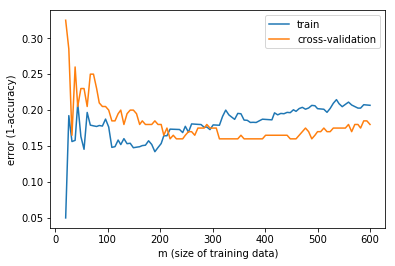

In [40]:
# first we split the training set into a training / validation set (as we are using k-folds cross validation elsewhere and don't have an explicit training and validation set.)
X_train_train, X_cv, y_train_train, y_cv = model_selection.train_test_split(X_train, y_train, test_size=0.25, stratify=y_train)

# set the model to calculate learning curves for
#model = neural_network.MLPClassifier(solver='lbfgs', activation='relu', alpha=alpha, hidden_layer_sizes=hidden_layer_sizes, random_state=1)

m_array = np.round(np.linspace(20, X_train_train.shape[0], 100)).astype(int)
train_acc_array = []
cv_acc_array = []

for m in m_array:
    model = linear_model.LogisticRegression(fit_intercept=True)
    # we now fit to the training data
    model.fit(X_train_train.head(m), y_train_train.head(m)) # training on the first m training data examples
    train_accuracy = model.score(X_train_train.head(m), y_train_train.head(m))
    train_acc_array.append(train_accuracy)
    cv_accuracy = model.score(X_cv, y_cv)
    cv_acc_array.append(cv_accuracy)

train_acc_array = np.array(train_acc_array)
cv_acc_array = np.array(cv_acc_array)

fig, ax = plt.subplots()
ax.plot(m_array, 1-train_acc_array, label='train')
ax.plot(m_array, 1-cv_acc_array, label='cross-validation')
ax.legend()
ax.set_xlabel('m (size of training data)')
ax.set_ylabel('error (1-accuracy)')

This learning curve is typical of a high bias algorithm. Getting more data will not help improve the fitting, adding more features might.

## Support Vector Machine

### Linear Kernel

In [80]:
C = 1 # start with penalty parameter equal to 1 as we don't know what value this should take yet, larger C -> lower bias, higher variance, smaller C -> higher bias, lower varaince. Since we don't have that much data a lower bias algorithm is probably best to avoid overfitting

kernel = 'linear' # we'll start with a simple linear kernal to see how ths performs

svm_model = svm.SVC(C=C, kernel=kernel)

In [81]:
N_splits = 10
kfold = model_selection.KFold(n_splits=N_splits)

scoring = 'accuracy'
score = model_selection.cross_val_score(svm_model, X_train, y_train, cv=kfold, n_jobs=1, scoring=scoring)


In [82]:
score.mean()*100 # we get an average accuracy of ~78.5% over 10 folds with logistic regression

78.625000000000014

In [83]:
score.var()*100 # we get a variance of ~0.2% so the accuracy is also pretty consistant

0.54203125000000019

In [84]:
C_array = np.array([0.003, 0.01, 0.02, 0.03, 0.05, 0.1, 0.3, 1, 3, 10])
acc_mean_array = np.zeros_like(C_array)
acc_variance_array = np.zeros_like(C_array)
for i, C in enumerate(C_array):
    print(i, C)
    svm_model = svm.SVC(C=C, kernel=kernel)  
    score = model_selection.cross_val_score(svm_model, X_train, y_train, cv=kfold, n_jobs=1, scoring=scoring)
    acc_mean_array[i] = score.mean()*100
    acc_variance_array[i] = score.var()*100

0 0.003
1 0.01
2 0.02
3 0.03
4 0.05
5 0.1
6 0.3
7 1.0
8 3.0
9 10.0


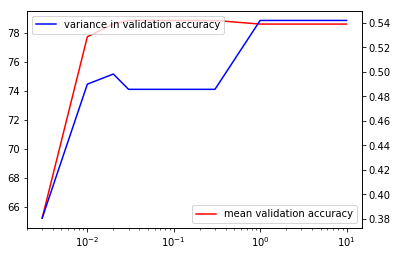

In [85]:
fig, ax = plt.subplots()
ax.plot(C_array, acc_mean_array, label='mean validation accuracy', color='red')
ax2 = ax.twinx()
ax2.plot(C_array, acc_variance_array, label='variance in validation accuracy', color='blue')
ax.semilogx()
ax.legend()
ax2.legend()

From this we can conclude that a value of C=0.1 is best for a linear kernel SVM.

In [86]:
N_splits = 10
kfold = model_selection.KFold(n_splits=N_splits)

scoring = 'accuracy'
score = model_selection.cross_val_score(svm_model, X_train, y_train, cv=kfold, n_jobs=1, scoring=scoring)

print("mean = {}".format(score.mean()*100)) # we get an average accuracy of ~78.5% over 10 folds with logistic regression

print("variance = {}".format(score.var()*100)) # we get a variance of ~0.2% so the accuracy is also pretty consistant

mean = 78.62500000000001
variance = 0.5420312500000002


In [87]:
bestC = 0.1
svm_model = svm.SVC(C=bestC, kernel=kernel)
# we now train our model
svm_model.fit(X_train, y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [88]:
# and test it on our test data we have held back from the training/validation set
svm_model.score(X_test, y_test) 

0.7640449438202247

We actually get 76% accuracy slightly lower than for the validation data, this is expected as we have tuned the hyperparameter C to perform best on the validation data. This is also similar to that we got with the logistic regression, not suprising since a SVM with a linear kernal is a very similar algorithm. This suggests the model is fitted correctly and is performing well, we now predict on Kaggle's test data and save the prediction to submit to Kaggle.

In [89]:
prediction = svm_model.predict(data_test)

with open('prediction_submission_SVM_linear_kernel.csv', 'w') as file:
    print('PassengerId,Survived', file=file)
    for i, id_ in enumerate(data_test.index):
        print('{},{}'.format(id_, prediction[i]), file=file)


When we submit this result to Kaggle we get a reported accuracy of **~76.5%** which is again very similar to when we evaluated on our held back test data.

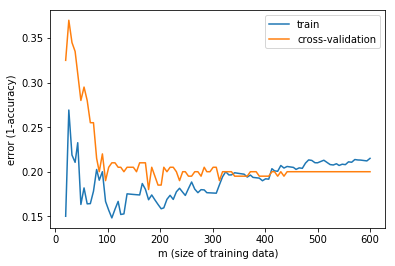

In [96]:
# first we split the training set into a training / validation set (as we are using k-folds cross validation elsewhere and don't have an explicit training and validation set.)
X_train_train, X_cv, y_train_train, y_cv = model_selection.train_test_split(X_train, y_train, test_size=0.25, stratify=y_train)

# set the model to calculate learning curves for
#model = neural_network.MLPClassifier(solver='lbfgs', activation='relu', alpha=alpha, hidden_layer_sizes=hidden_layer_sizes, random_state=1)

m_array = np.round(np.linspace(20, X_train_train.shape[0], 100)).astype(int)
train_acc_array = []
cv_acc_array = []

for m in m_array:
    model = svm.SVC(C=bestC, kernel=kernel)
    # we now fit to the training data
    model.fit(X_train_train.head(m), y_train_train.head(m)) # training on the first m training data examples
    train_accuracy = model.score(X_train_train.head(m), y_train_train.head(m))
    train_acc_array.append(train_accuracy)
    cv_accuracy = model.score(X_cv, y_cv)
    cv_acc_array.append(cv_accuracy)

train_acc_array = np.array(train_acc_array)
cv_acc_array = np.array(cv_acc_array)

fig, ax = plt.subplots()
ax.plot(m_array, 1-train_acc_array, label='train')
ax.plot(m_array, 1-cv_acc_array, label='cross-validation')
ax.legend()
ax.set_xlabel('m (size of training data)')
ax.set_ylabel('error (1-accuracy)')

This learning curve is also typical of a high bias algorithm. Getting more data will not help improve the fitting, adding more features might.

### Gaussian Kernel

In [97]:
C = 1 # start with penalty parameter equal to 1 as we don't know what value this should take yet, larger C -> lower bias, higher variance, smaller C -> higher bias, lower varaince. Since we don't have that much data a lower bias algorithm is probably best to avoid overfitting

kernel = 'rbf' # we'll use the radial basis function (Gaussian) kernal to see how ths performs

gamma = 'auto' # a second hyperparameter to tune for the Guassian kernal - the width of the Gaussian function used


In [98]:
svm_model = svm.SVC(C=C, kernel=kernel, gamma=gamma)

N_splits = 10
kfold = model_selection.KFold(n_splits=N_splits)

scoring = 'accuracy'
score = model_selection.cross_val_score(svm_model, X_train, y_train, cv=kfold, n_jobs=1, scoring=scoring)

print("mean score: {}".format(score.mean()))
print("variance in score: {}".format(score.var()))

mean score: 0.82
variance in score: 0.003506250000000001


In [99]:
C_array = np.array([0.003, 0.01, 0.02, 0.03, 0.05, 0.1, 0.3, 1, 3, 10, 30])
acc_mean_array = np.zeros_like(C_array)
acc_variance_array = np.zeros_like(C_array)
for i, C in enumerate(C_array):
    print(i, C)
    svm_model = svm.SVC(C=C, kernel=kernel, gamma=gamma) 
    score = model_selection.cross_val_score(svm_model, X_train, y_train, cv=kfold, n_jobs=1, scoring=scoring)
    acc_mean_array[i] = score.mean()*100
    acc_variance_array[i] = score.var()*100

0 0.003
1 0.01
2 0.02
3 0.03
4 0.05
5 0.1
6 0.3
7 1.0
8 3.0
9 10.0
10 30.0


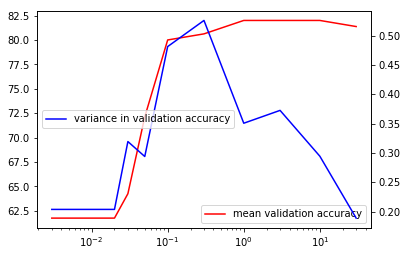

In [100]:
fig, ax = plt.subplots()
ax.plot(C_array, acc_mean_array, label='mean validation accuracy', color='red')
ax2 = ax.twinx()
ax2.plot(C_array, acc_variance_array, label='variance in validation accuracy', color='blue')
ax.semilogx()
ax.legend()
ax2.legend()

In [101]:
C_array[np.argmax(acc_mean_array)]

1.0

In [102]:
bestC = 1

In [104]:
svm_model = svm.SVC(C=bestC, kernel=kernel, gamma=gamma)
svm_model.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [105]:
svm_model.score(X_test, y_test)

0.8202247191011236

In [106]:
prediction = svm_model.predict(data_test)

with open('prediction_submission_SVM_gaussian_kernel.csv', 'w') as file:
    print('PassengerId,Survived', file=file)
    for i, id_ in enumerate(data_test.index):
        print('{},{}'.format(id_, prediction[i]), file=file)

When we submit this result to Kaggle we get a reported accuracy of ~78.5% which is quite a bit less than the accuracy we got when we evaluated it on our held back test data, but still the best score we have got with any learning algorithm so far.

I'm not sure why the accuracy on the held-out test data and Kaggle test data is so different. Possibly there are examples in the Kaggle data that are unlike any in the training data given by Kaggle (i.e. my train/validation and test data I use here with known values of the target variable) so my learning algorithm can't categorise them correctly. Or maybe there is a data leak from the held-out test data into the train data (imputing the average on all the Kaggle training data for example may be an issue?) causing it to perform better for my held-out test data than Kaggle's test data.

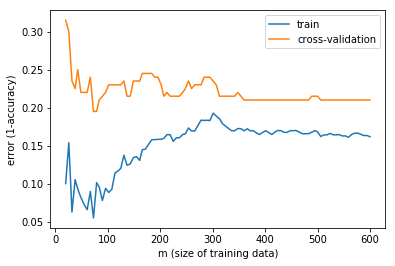

In [113]:
# first we split the training set into a training / validation set (as we are using k-folds cross validation elsewhere and don't have an explicit training and validation set.)
X_train_train, X_cv, y_train_train, y_cv = model_selection.train_test_split(X_train, y_train, test_size=0.25, stratify=y_train)

# set the model to calculate learning curves for
#model = neural_network.MLPClassifier(solver='lbfgs', activation='relu', alpha=alpha, hidden_layer_sizes=hidden_layer_sizes, random_state=1)

m_array = np.round(np.linspace(20, X_train_train.shape[0], 100)).astype(int)
train_acc_array = []
cv_acc_array = []

for m in m_array:
    model = svm.SVC(C=bestC, kernel=kernel, gamma=gamma)
    # we now fit to the training data
    model.fit(X_train_train.head(m), y_train_train.head(m)) # training on the first m training data examples
    train_accuracy = model.score(X_train_train.head(m), y_train_train.head(m))
    train_acc_array.append(train_accuracy)
    cv_accuracy = model.score(X_cv, y_cv)
    cv_acc_array.append(cv_accuracy)

train_acc_array = np.array(train_acc_array)
cv_acc_array = np.array(cv_acc_array)

fig, ax = plt.subplots()
ax.plot(m_array, 1-train_acc_array, label='train')
ax.plot(m_array, 1-cv_acc_array, label='cross-validation')
ax.legend()
ax.set_xlabel('m (size of training data)')
ax.set_ylabel('error (1-accuracy)')

This learning curve suggests that the Gaussian SVM is a high variance algorithm for this problem and amount of data. Getting more data will help improve the fitting, adding more features will just increase the variance and amount of data needed to fit. 

# Neural Network

In [136]:
hidden_layer_sizes=(10,10)
alpha=1e-1

nn_model = neural_network.MLPClassifier(solver='lbfgs', activation='relu', alpha=alpha, hidden_layer_sizes=hidden_layer_sizes, random_state=1)

In [137]:
N_splits = 10
kfold = model_selection.KFold(n_splits=N_splits)

scoring = 'accuracy'
score = model_selection.cross_val_score(nn_model, X_train, y_train, cv=kfold, n_jobs=1, scoring=scoring)

print("mean score: {}".format(score.mean()))
print("variance in score: {}".format(score.var()))

mean score: 0.7925
variance in score: 0.003131250000000002


In [138]:
nn_model = neural_network.MLPClassifier(solver='lbfgs', activation='relu', alpha=alpha, hidden_layer_sizes=hidden_layer_sizes, random_state=1)

nn_model.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [139]:
nn_model.score(X_test, y_test)

0.7865168539325843

In [140]:
prediction = nn_model.predict(data_test)

with open('prediction_submission_nn.csv', 'w') as file:
    print('PassengerId,Survived', file=file)
    for i, id_ in enumerate(data_test.index):
        print('{},{}'.format(id_, prediction[i]), file=file)

For this we get 72% performance on the Kaggle test data. Lets take a look at the learning curve for this neural network to see if we can figure out what's going on.

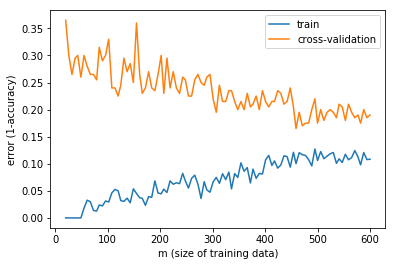

In [141]:
# first we split the training set into a training / validation set (as we are using k-folds cross validation elsewhere and don't have an explicit training and validation set.)
X_train_train, X_cv, y_train_train, y_cv = model_selection.train_test_split(X_train, y_train, test_size=0.25, stratify=y_train)

# set the model to calculate learning curves for
#model = neural_network.MLPClassifier(solver='lbfgs', activation='relu', alpha=alpha, hidden_layer_sizes=hidden_layer_sizes, random_state=1)

m_array = np.round(np.linspace(20, X_train_train.shape[0], 100)).astype(int)
train_acc_array = []
cv_acc_array = []

for m in m_array:
    model = neural_network.MLPClassifier(solver='lbfgs', activation='relu', alpha=alpha, hidden_layer_sizes=hidden_layer_sizes, random_state=1)
    # we now fit to the training data
    model.fit(X_train_train.head(m), y_train_train.head(m)) # training on the first m training data examples
    train_accuracy = model.score(X_train_train.head(m), y_train_train.head(m))
    train_acc_array.append(train_accuracy)
    cv_accuracy = model.score(X_cv, y_cv)
    cv_acc_array.append(cv_accuracy)

train_acc_array = np.array(train_acc_array)
cv_acc_array = np.array(cv_acc_array)

fig, ax = plt.subplots()
ax.plot(m_array, 1-train_acc_array, label='train')
ax.plot(m_array, 1-cv_acc_array, label='cross-validation')
ax.legend()
ax.set_xlabel('m (size of training data)')
ax.set_ylabel('error (1-accuracy)')

This learning curve suggests that the neural network is a high variance algorithm for this problem and amount of training data. Getting more data will help improve the fitting, adding more features will just increase the variance and amount of data needed to fit. More data would cause this gap between the 2 error curves to drop such that the accuracy improved overall.

In [142]:
hidden_layer_sizes=(3,3)
alpha=1e-1

nn_model = neural_network.MLPClassifier(solver='lbfgs', activation='relu', alpha=alpha, hidden_layer_sizes=hidden_layer_sizes, random_state=1)

In [143]:
N_splits = 10
kfold = model_selection.KFold(n_splits=N_splits)

scoring = 'accuracy'
score = model_selection.cross_val_score(nn_model, X_train, y_train, cv=kfold, n_jobs=1, scoring=scoring)

print("mean score: {}".format(score.mean()))
print("variance in score: {}".format(score.var()))

mean score: 0.8175000000000001
variance in score: 0.00350625


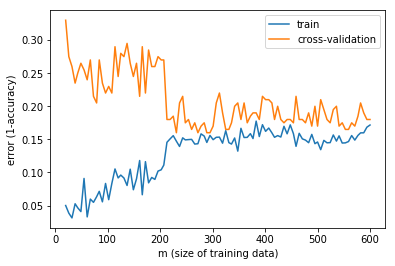

In [144]:
# first we split the training set into a training / validation set (as we are using k-folds cross validation elsewhere and don't have an explicit training and validation set.)
X_train_train, X_cv, y_train_train, y_cv = model_selection.train_test_split(X_train, y_train, test_size=0.25, stratify=y_train)

# set the model to calculate learning curves for
#model = neural_network.MLPClassifier(solver='lbfgs', activation='relu', alpha=alpha, hidden_layer_sizes=hidden_layer_sizes, random_state=1)

m_array = np.round(np.linspace(20, X_train_train.shape[0], 100)).astype(int)
train_acc_array = []
cv_acc_array = []

for m in m_array:
    model = neural_network.MLPClassifier(solver='lbfgs', activation='relu', alpha=alpha, hidden_layer_sizes=hidden_layer_sizes, random_state=1)
    # we now fit to the training data
    model.fit(X_train_train.head(m), y_train_train.head(m)) # training on the first m training data examples
    train_accuracy = model.score(X_train_train.head(m), y_train_train.head(m))
    train_acc_array.append(train_accuracy)
    cv_accuracy = model.score(X_cv, y_cv)
    cv_acc_array.append(cv_accuracy)

train_acc_array = np.array(train_acc_array)
cv_acc_array = np.array(cv_acc_array)

fig, ax = plt.subplots()
ax.plot(m_array, 1-train_acc_array, label='train')
ax.plot(m_array, 1-cv_acc_array, label='cross-validation')
ax.legend()
ax.set_xlabel('m (size of training data)')
ax.set_ylabel('error (1-accuracy)')

This learning curve looks much better, the validation and training error are much closer for larger values of m. This means this much simpler neural network with much less hidden units in each layer is a much lower variance learning algorithm, which makes sense as it is less complex.

In [145]:
nn_model = neural_network.MLPClassifier(solver='lbfgs', activation='relu', alpha=alpha, hidden_layer_sizes=hidden_layer_sizes, random_state=1)

nn_model.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(3, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [146]:
nn_model.score(X_test, y_test)

0.8314606741573034

In [147]:
prediction = nn_model.predict(data_test)

with open('prediction_submission_nn.csv', 'w') as file:
    print('PassengerId,Survived', file=file)
    for i, id_ in enumerate(data_test.index):
        print('{},{}'.format(id_, prediction[i]), file=file)

We now with this much smaller hidden layer neural network get 77% accuracy, much better than with the higher variance neural network model.